In [1]:
# Preparation

import matplotlib
from matplotlib import patches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import os
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import pearsonr, mannwhitneyu
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

from src.fitness_landscape import *
from src.time_series_generation import *

cmap = plt.get_cmap('tab10')
sns.set_style("ticks")
sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'axes.labelsize': 16})
matplotlib.rcParams.update({'legend.fontsize': 16})
matplotlib.rcParams.update({'xtick.labelsize': 16, 'ytick.labelsize': 16})

os.makedirs('./plots', exist_ok=True)
save_path = './plots/'
env_list = pd.read_excel('./data/strain_num_matching.xlsx', index_col=0)

# Figure 1

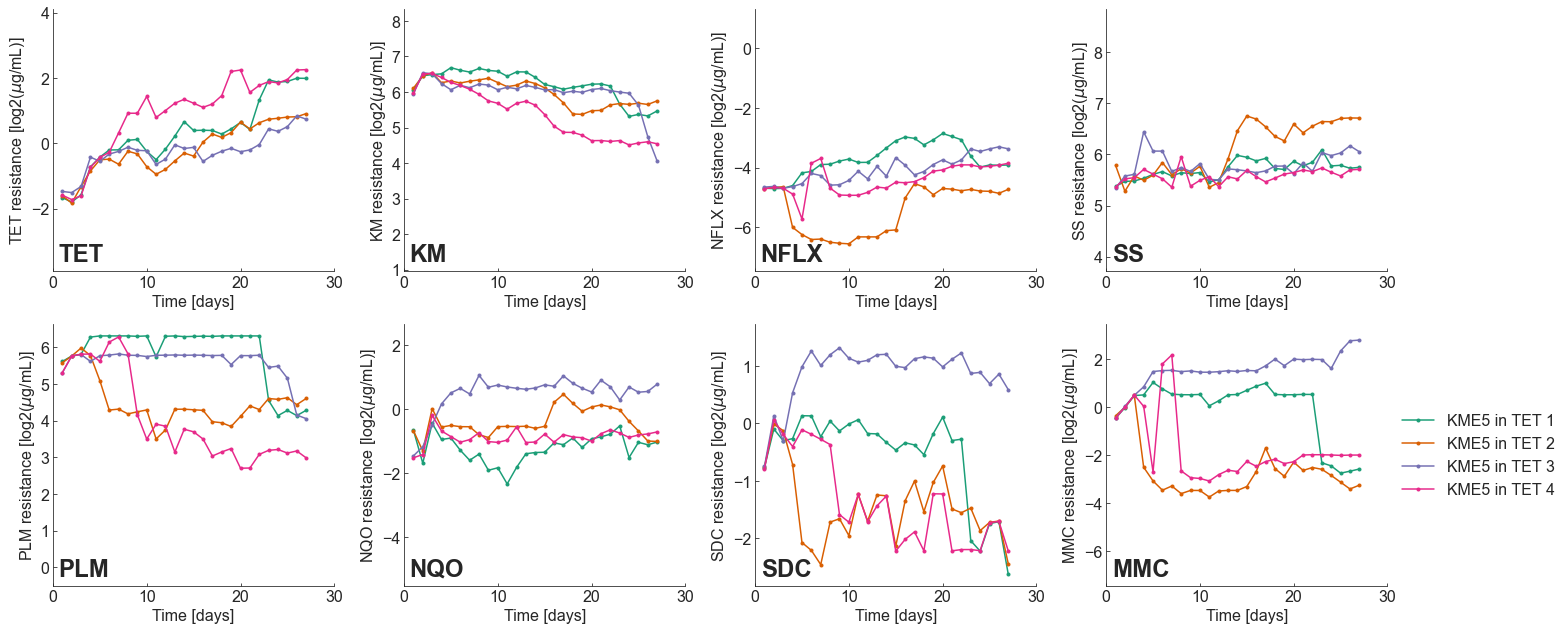

In [2]:
# plot resistance time series using day0 data as Parent IC50 and relative resistance from Maeda 2020
cmap2 = plt.get_cmap("Dark2")

# set parent resistance to day 0 data, and use relative resistance from Maeda 2020.
# find parent strains
parent_bool = strain_name_df['strain_env'].str.contains('Parent').values
# output index for parent strains
parent_index = strain_name_df.iloc[parent_bool].index.values

day0_ic50 = pd.DataFrame(index=stress_list)
day = 0
for strain in parent_index:
    df = pd.read_csv('./data/trajectories/strain' + str(strain) + '.csv',
                     index_col=0)
    day0_ic50['strain' + str(strain)] = df.iloc[:, day]
day0_mean = day0_ic50.mean(axis=1)

parent_ic50 = day0_mean

left, bottom = .02, .02  # parameters for locating stress names in the plot
top = .88
num_strains = 4

#for start_strain in range(1, 49, 4):
for start_strain in range(9, 13, 4):
    plt.subplots(2, 4, figsize=(22, 9))

    for j, stress in enumerate(stress_list):
        ax = plt.subplot(2, 4, j + 1)

        for strain in range(1, 61):
            # environment and evolved strain
            plot_time_series(strain,
                             stress,
                             color=cmap(7),
                             marker='',
                             alpha=0,
                             print_title=False)

        for i, strain in enumerate(
                range(start_strain, start_strain + num_strains)):
            plot_time_series(strain,
                             stress,
                             color=cmap2(i),
                             zorder=3,
                             alpha=1,
                             i=i,
                             print_title=False,
                             label='KME5 in TET ' + str(i + 1))

        # get IC50 value from Maeda et al 2020.
        strain_env = strain_name_df.iloc[strain - 1, 0]
        strain_name_len = strain_env.find('in') - 1
        strain_name = strain_env[:strain_name_len]
        if strain_name == 'Parent':
            ic50_value = parent_ic50[stress]
        else:
            ic50_value = evo192_res.loc[strain_name][stress] + \
                parent_ic50[stress]
        std = day0_ic50.std(axis=1)[stress]

        plt.xlim(0, 30)
        plt.ylabel(stress + ' resistance [log2($\mu$g/mL)]')
        plt.xlabel('Time [days]')

        ax.text(left,
                bottom,
                stress,
                horizontalalignment='left',
                verticalalignment='bottom',
                transform=ax.transAxes,
                fontsize=24,
                fontweight='bold')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if j == 7:
            plt.legend(loc='center left',
                       bbox_to_anchor=(1, 0.5),
                       frameon=False)

    plt.tight_layout()
    plt.savefig(save_path + "Fig1.pdf", dpi=300, bbox_inches="tight")
    plt.show()

# Figure 2

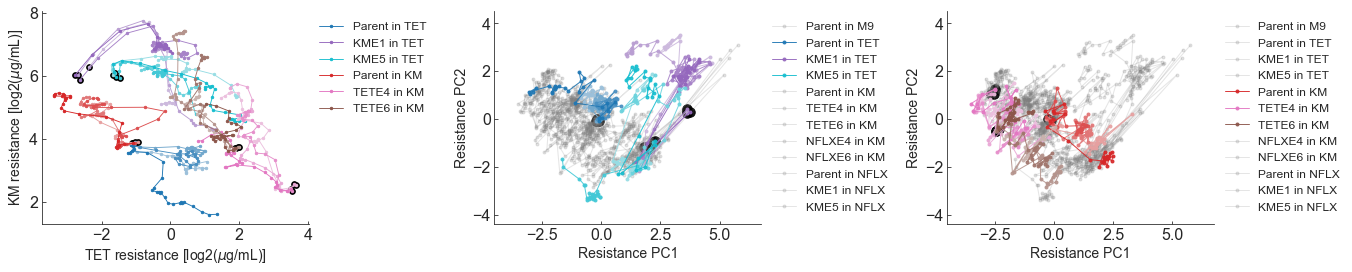

In [3]:
# Plot trajectories in the TET-KM and PCA space

roll_win = 3
alph = 0.2
matplotlib.rcParams.update({'legend.fontsize': 12})

sns_theme = "tab10"
c_parent_tet = "light:"+sns.color_palette(sns_theme).as_hex()[0]
c_km1_tet = "light:"+sns.color_palette(sns_theme).as_hex()[4]
c_km5_tet = 'light:'+sns.color_palette(sns_theme).as_hex()[9]
c_parent_km = "light:"+sns.color_palette().as_hex()[3]
c_tet4_km = "light:"+sns.color_palette(sns_theme).as_hex()[6]
c_tet6_km = "light:"+sns.color_palette(sns_theme).as_hex()[5]

plt.subplots(1, 3, figsize=(19, 4))

ax1 = plt.subplot(1, 3, 1)
stress1 = 'TET'
stress2 = 'KM'

df = pd.read_csv('./data/trajectories/strain1.csv', index_col=0)
plot_strain(1,
            4,
            stress1,
            stress2,
            'Parent in TET',
            roll_win=roll_win,
            cmap_name=c_parent_tet)
plot_strain(5,
            8,
            stress1,
            stress2,
            'KME1 in TET',
            roll_win=roll_win,
            cmap_name=c_km1_tet)
plot_strain(9,
            12,
            stress1,
            stress2,
            'KME5 in TET',
            roll_win=roll_win,
            cmap_name=c_km5_tet)
plot_strain(13,
            16,
            stress1,
            stress2,
            'Parent in KM',
            roll_win=roll_win,
            cmap_name=c_parent_km)
plot_strain(17,
            20,
            stress1,
            stress2,
            'TETE4 in KM',
            roll_win=roll_win,
            cmap_name=c_tet4_km)
plot_strain(21,
            24,
            stress1,
            stress2,
            'TETE6 in KM',
            roll_win=roll_win,
            cmap_name=c_tet6_km)

trajectory1 = df.loc[stress1].iloc[0:]
trajectory2 = df.loc[stress2].iloc[0:]

plt.xlabel(stress1 + ' resistance [log2($\mu$g/mL)]', fontsize=14)
plt.ylabel(stress2 + ' resistance [log2($\mu$g/mL)]', fontsize=14)
plt.legend(frameon=False, bbox_to_anchor=(1., 1))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = plt.subplot(1, 3, 2)
traj_pca_df = pd.DataFrame()
traj_pca_df = plot_pca_traj('Parent in M9',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('Parent in TET',
                            traj_pca_df=traj_pca_df,
                            c=c_parent_tet,
                            zorder=3)
traj_pca_df = plot_pca_traj('KME1 in TET',
                            traj_pca_df=traj_pca_df,
                            c=c_km1_tet,
                            zorder=3)
traj_pca_df = plot_pca_traj('KME5 in TET',
                            traj_pca_df=traj_pca_df,
                            c=c_km5_tet,
                            zorder=3)
traj_pca_df = plot_pca_traj('Parent in KM',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('TETE4 in KM',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('TETE6 in KM',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('NFLXE4 in KM',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('NFLXE6 in KM',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('Parent in NFLX',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('KME1 in NFLX',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('KME5 in NFLX',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
plt.xlim(traj_pca_df.iloc[:, 0].min() - 1, traj_pca_df.iloc[:, 0].max() + 1)
plt.ylim(traj_pca_df.iloc[:, 1].min() - 1, traj_pca_df.iloc[:, 1].max() + 1)
plt.xlabel('Resistance PC1', fontsize=14)
plt.ylabel('Resistance PC2', fontsize=14)
plt.legend(frameon=False, bbox_to_anchor=(1., 1))
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax3 = plt.subplot(1, 3, 3)
traj_pca_df = pd.DataFrame()
traj_pca_df = plot_pca_traj('Parent in M9',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('Parent in TET',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('KME1 in TET',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('KME5 in TET',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('Parent in KM',
                            traj_pca_df=traj_pca_df,
                            c=c_parent_km,
                            zorder=3)
traj_pca_df = plot_pca_traj('TETE4 in KM',
                            traj_pca_df=traj_pca_df,
                            c=c_tet4_km,
                            zorder=3)
traj_pca_df = plot_pca_traj('TETE6 in KM',
                            traj_pca_df=traj_pca_df,
                            c=c_tet6_km,
                            zorder=3)
traj_pca_df = plot_pca_traj('NFLXE4 in KM',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('NFLXE6 in KM',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('Parent in NFLX',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('KME1 in NFLX',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
traj_pca_df = plot_pca_traj('KME5 in NFLX',
                            traj_pca_df=traj_pca_df,
                            c="gray",
                            alpha=alph)
plt.xlim(traj_pca_df.iloc[:, 0].min() - 1, traj_pca_df.iloc[:, 0].max() + 1)
plt.ylim(traj_pca_df.iloc[:, 1].min() - 1, traj_pca_df.iloc[:, 1].max() + 1)
plt.xlabel('Resistance PC1', fontsize=14)
plt.ylabel('Resistance PC2', fontsize=14)
plt.legend(frameon=False, bbox_to_anchor=(1., 1))
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(save_path + "Fig2.pdf", dpi=300, bbox_inches="tight")

# Figure 3

<ipython-input-4-408d46a7213c>:82: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3, 3, 9).remove()


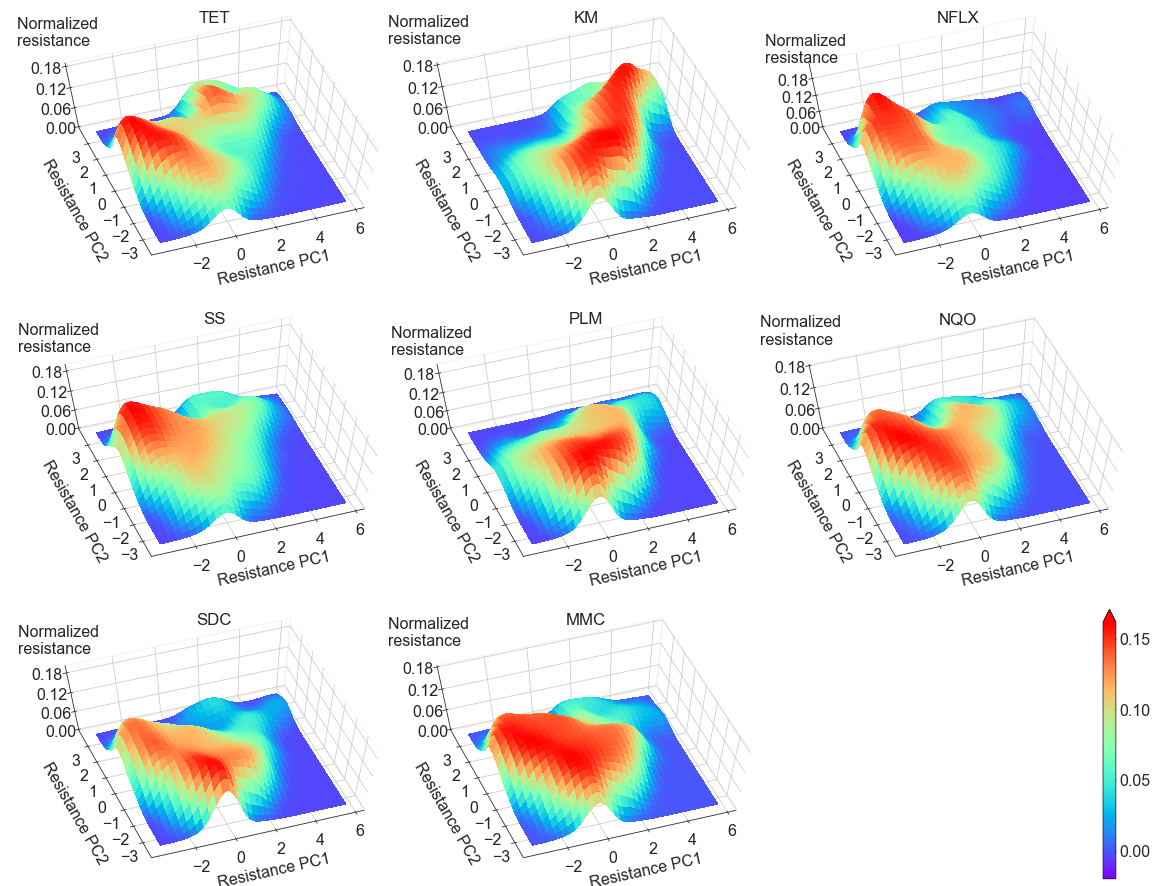

In [4]:
# 3d fitness landscape for all stresses using heuristic grid_size and h defined by CV

h = 0.9  # bandwidth decided by cross validation
colormap = plt.get_cmap('rainbow', 256)
high_res = False
if high_res:
    stride = 30
    res = 1000  # resolution
else:
    stride = 10
    res = 300  # resolution
    
z_max_store = []

plt.subplots(3, 3, figsize=(15, 11))
for stress_index in range(8):
    fitness, ave_quantized = quantize_map(stress_index=stress_index,
                                          grid_size=grid_size)
    nonnan_loc = np.argwhere(~np.isnan(ave_quantized))

    rel_fit = ave_quantized - np.nanmin(ave_quantized)
    rel_fit = [
        rel_fit[nonnan_loc[i][0], nonnan_loc[i][1]]
        for i in range(nonnan_loc.shape[0])
    ]
    mu1 = nonnan_loc[:, 1]
    mu2 = nonnan_loc[:, 0]

    # convert parameters to units of the PCA space
    Mu1 = mu1 * grid_size + x_min
    Mu2 = mu2 * grid_size + y_min
    H = h * grid_size

    X = np.linspace(x_min, x_max, res)
    Y = np.linspace(y_min, y_max, res)
    XX, YY = np.meshgrid(X, Y, sparse=True)
    Z = fitted_2d_func(XX, YY, Mu1, Mu2, H, H, rel_fit)

    ax = plt.subplot(3, 3, stress_index + 1, projection='3d')
    im = ax.plot_surface(XX,
                         YY,
                         Z,
                         cmap=colormap,
                         linewidth=0,
                         cstride=stride,
                         rstride=stride,
                         antialiased=False,
                         shade=True,
                         clim=(0, Z.max()),
                         vmin=-0.02
                        )

    z_max_store.append(Z.max())
    plt.title(stress_list[stress_index])
    ax.view_init(66, 250)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('Resistance PC1', linespacing=1)
    ax.set_ylabel('Resistance PC2')
    ax.zaxis.set_rotate_label(False)
    ax.text(-6, 4.4, 0.24, s='Normalized \nresistance', fontsize=16)
    ax.set_zticks(np.linspace(0, 0.18, 4))
    ax.xaxis.labelpad = 15
    ax.yaxis.labelpad = 15

    if stress_index == 7:
        ax = plt.subplot(3, 3, 9)
        im = ax.imshow(np.random.rand(3, 3),
                       clim=(0, np.min(np.array(z_max_store))),
                       cmap=colormap,
                       vmin=-0.02
                      )
        plt.colorbar(im,
                     extend='max',
                     panchor=(-1, 0.5),
                     ticks=np.linspace(0, 0.15, 4),
                     norm=matplotlib.colors.Normalize(
                         vmin=-0.02, vmax=np.min(np.array(z_max_store))),
                    )

plt.subplot(3, 3, 9).remove()
plt.tight_layout(pad=-3, h_pad=2.0)
plt.savefig(save_path + "Fig3.pdf", dpi=300, bbox_inches="tight")

# Figure 4

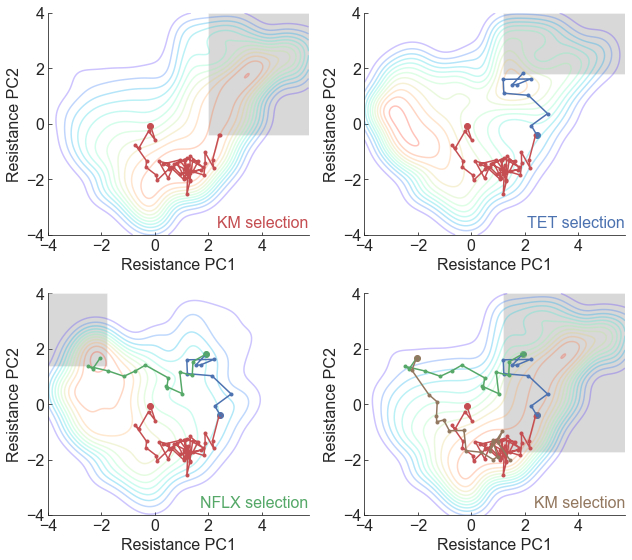

In [5]:
# Simulated trajectories in the exerimentally constructed fitness landscape
seed = 124
np.random.seed(seed)  # nice seeds: 118, 124

max_steps = 200
eta = 0.4
noise_strength = 0.3
num_runs = 10
cm = sns.color_palette("deep", as_cmap=True)

x1, x2, y1, y2 = (-4, x_max, -4, 4)
res = 1000  # resolution for drawing the landscape
X = np.linspace(x1, x2, res)
Y = np.linspace(y1, y2, res)
XX, YY = np.meshgrid(X, Y, sparse=True)

plt.subplots(2, 2, figsize=(9, 8))

stress_index = 1  # KM environment
l_params = landscape_props(stress_index)
Mu1, Mu2, H, rel_fit = l_params
Z_KM = fitted_2d_func(XX, YY, Mu1, Mu2, H, H, rel_fit)

# generate a trajectory statrting from the state of the Parent strain.
parent_state = get_init_state('Parent in KM').mean(axis=0)
traj = grad_ascent(wrap_grad,
                   parent_state,
                   stress_index,
                   l_params,
                   n_epochs=1,
                   eta=eta,
                   noise_strength=noise_strength)

x_thre1 = 2
y_thre1 = -0.4
for step in range(max_steps):
    # new_traj: np.array([init_state, next_state]) # shape = (2,2)
    new_traj = grad_ascent(wrap_grad,
                           traj[-1, :],
                           stress_index,
                           l_params,
                           n_epochs=1,
                           eta=eta,
                           noise_strength=noise_strength)
    traj = np.append(traj, new_traj[-1, :].reshape(1, 2), axis=0)

    if (traj[-1, 0] > x_thre1) and (traj[-1, 1] > y_thre1):
        KM_steps = traj.shape[0]
        break

ax = plt.subplot(2, 2, 1)
plot_traj(traj[:KM_steps, :], color=cm[3], alpha=1)
plt.contour(X,
            Y,
            Z_KM,
            levels=13,
            cmap=plt.get_cmap('rainbow', 256),
            alpha=0.3)
r = patches.Rectangle(xy=(x_thre1, y_thre1),
                      width=x2 - x_thre1,
                      height=y2 - y_thre1,
                      fc='gray',
                      alpha=0.3)
ax.add_patch(r)
plt.xlabel('Resistance PC1')
plt.ylabel('Resistance PC2')
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.text(x=1, y=0.02, s='KM selection', color=cm[3], verticalalignment="bottom",
         horizontalalignment='right', transform = ax.transAxes, fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

stress_index = 0  # TET environment
l_params = landscape_props(stress_index)
Mu1, Mu2, H, rel_fit = l_params
Z_TET = fitted_2d_func(XX, YY, Mu1, Mu2, H, H, rel_fit)

x_thre2 = 1.2
y_thre2 = 1.8
for step in range(max_steps):
    # new_traj: np.array([init_state, next_state]) # shape = (2,2)
    new_traj = grad_ascent(wrap_grad,
                           traj[-1, :],
                           stress_index,
                           l_params,
                           n_epochs=1,
                           eta=eta,
                           noise_strength=noise_strength)
    traj = np.append(traj, new_traj[-1, :].reshape(1, 2), axis=0)

    if (traj[-1, 0] > x_thre2) and (traj[-1, 1] > y_thre2):
        TET_steps = traj.shape[0] - KM_steps
        break

ax = plt.subplot(2, 2, 2)
plot_traj(traj[:KM_steps, :], color=cm[3], alpha=1)
plot_traj(traj[KM_steps - 1:, :], color=cm[0], alpha=1)
plt.contour(X,
            Y,
            Z_TET,
            levels=13,
            cmap=plt.get_cmap('rainbow', 256),
            alpha=0.3)
r = patches.Rectangle(xy=(x_thre2, y_thre2),
                      width=x2 - x_thre2,
                      height=y2 - y_thre2,
                      fc='gray',
                      alpha=0.3)
ax.add_patch(r)
plt.xlabel('Resistance PC1')
plt.ylabel('Resistance PC2')
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.text(x=1, y=0.02, s='TET selection', color=cm[0], verticalalignment="bottom",
         horizontalalignment='right', transform = ax.transAxes, fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

stress_index = 2  # NFLX environment
l_params = landscape_props(stress_index)
Mu1, Mu2, H, rel_fit = l_params
Z_NFLX = fitted_2d_func(XX, YY, Mu1, Mu2, H, H, rel_fit)

x_thre3 = -1.8
y_thre3 = 1.4
for step in range(max_steps):
    # new_traj: np.array([init_state, next_state]) # shape = (2,2)
    new_traj = grad_ascent(wrap_grad,
                           traj[-1, :],
                           stress_index,
                           l_params,
                           n_epochs=1,
                           eta=eta,
                           noise_strength=noise_strength)
    traj = np.append(traj, new_traj[-1, :].reshape(1, 2), axis=0)
    if (traj[-1, 0] < x_thre3) and (traj[-1, 1] > y_thre3):
        NFLX_steps = traj.shape[0] - KM_steps - TET_steps
        break

ax = plt.subplot(2, 2, 3)
plot_traj(traj[:KM_steps, :], color=cm[3], alpha=1)
plot_traj(traj[KM_steps - 1:KM_steps + TET_steps, :], color=cm[0], alpha=1)
plot_traj(traj[KM_steps + TET_steps - 1:, :], color=cm[2], alpha=1)
plt.contour(X,
            Y,
            Z_NFLX,
            levels=13,
            cmap=plt.get_cmap('rainbow', 256),
            alpha=0.3)
r = patches.Rectangle(xy=(x1, y_thre3),
                      width=x_thre3 - x1,
                      height=y2 - y_thre3,
                      fc='gray',
                      alpha=0.3)
ax.add_patch(r)
plt.xlabel('Resistance PC1')
plt.ylabel('Resistance PC2')
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.text(x=1, y=0.02, s='NFLX selection', color=cm[2], verticalalignment="bottom",
         horizontalalignment='right', transform = ax.transAxes, fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

stress_index = 1  # KM environment
l_params = landscape_props(stress_index)
Mu1, Mu2, H, rel_fit = l_params
Z = fitted_2d_func(XX, YY, Mu1, Mu2, H, H, rel_fit)
x_thre4 = 1.2
y_thre4 = -1.7

for step in range(max_steps):
    # new_traj: np.array([init_state, next_state]) # shape = (2,2)
    new_traj = grad_ascent(wrap_grad,
                           traj[-1, :],
                           stress_index,
                           l_params,
                           n_epochs=1,
                           eta=eta,
                           noise_strength=noise_strength)
    traj = np.append(traj, new_traj[-1, :].reshape(1, 2), axis=0)
    if (traj[-1, 0] > x_thre4) and (traj[-1, 1] < y_thre4):
        KM_steps2 = traj.shape[0] - KM_steps - TET_steps - NFLX_steps
        break

ax = plt.subplot(2, 2, 4)
plot_traj(traj[:KM_steps, :], color=cm[3], alpha=1)
plot_traj(traj[KM_steps - 1:KM_steps + TET_steps, :], color=cm[0], alpha=1)
plot_traj(traj[KM_steps + TET_steps - 1:KM_steps + TET_steps + NFLX_steps, :],
          color=cm[2],
          alpha=1)
plot_traj(traj[KM_steps + TET_steps + NFLX_steps - 1:, :],
          color=cm[5],
          alpha=1)
plt.contour(X, Y, Z, levels=13, cmap=plt.get_cmap('rainbow', 256), alpha=0.3)
r4 = patches.Rectangle(xy=(x_thre4, y_thre4),
                       width=x2 - x_thre4,
                       height=y2 - y_thre4,
                       fc='gray',
                       alpha=0.3)
ax.add_patch(r4)
plt.xlabel('Resistance PC1')
plt.ylabel('Resistance PC2')
plt.xlim(x1, x2)
plt.ylim(y1, y2)
plt.text(x=1, y=0.02, s='KM selection', color=cm[5], verticalalignment="bottom",
         horizontalalignment='right', transform = ax.transAxes, fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.savefig(save_path + "Fig4.pdf", dpi=300, bbox_inches="tight")
plt.show()